In [1]:
import pandas as pd
import matplotlib.pyplot as plt

covid_test_results_path = "/content/Covid_Test_Results.csv"
vaccination_records_path = "/content/Vaccination_Records.csv"
covid_test_results = pd.read_csv(covid_test_results_path)
vaccination_records = pd.read_csv(vaccination_records_path)

In [2]:
covid_test_results

,KisiHash,CovidTestSonucu,TestTarihi
0,8e4LF4XcPL,pozitif,2020-02-10
1,vbCfYSGIgL,negatif,2020-07-08
2,YhP1F6WjpG,pozitif,2022-12-07
3,FTG2hTWQqS,pozitif,2022-05-05
4,yVKDQPkfnt,negatif,2021-06-01
...,...,...,...
99995,zmLK11U1Jl,pozitif,2021-04-02
99996,nJ8xa3zA8A,negatif,2020-03-06
99997,qtJ2yAs9mm,pozitif,2020-04-01
99998,8JHHjWHIKC,pozitif,2021-05-26


In [3]:
vaccination_records

,KisiHash,AsiTarihi,AsiLotNo,AsiAdi
0,8e4LF4XcPL,2021-04-17,LotD,Biontech
1,vbCfYSGIgL,2020-07-03,LotD,Biontech
2,YhP1F6WjpG,2021-09-05,LotD,Biontech
3,FTG2hTWQqS,2022-09-25,LotD,Biontech
4,yVKDQPkfnt,2020-05-04,LotD,Biontech
...,...,...,...,...
99995,F3i5OVFwEw,2022-01-31,LotC,Sinovac
99996,ahkNtVz4Xp,2020-09-01,LotB,Biontech
99997,xc4Y7c2qyZ,2021-12-16,LotD,Biontech
99998,kc5lbxIQG6,2022-11-23,LotC,Sinovac


In [4]:
from datetime import datetime, timedelta

covid_test_results['TestTarihi'] = pd.to_datetime(covid_test_results['TestTarihi'])
vaccination_records['AsiTarihi'] = pd.to_datetime(vaccination_records['AsiTarihi'])

positive_cases = covid_test_results[covid_test_results['CovidTestSonucu'] == 'pozitif']
merged_data = pd.merge(positive_cases, vaccination_records, on='KisiHash')

merged_data['days_since_vaccination'] = (merged_data['TestTarihi'] - merged_data['AsiTarihi']).dt.days

filtered_data = merged_data[(merged_data['days_since_vaccination'] >= 14) & (merged_data['days_since_vaccination'] <= 180)]
lot_number_counts = filtered_data['AsiLotNo'].value_counts()



In [5]:
lot_number_counts

,count
AsiLotNo,
LotC,1741
LotD,1209
LotB,1107
LotA,1034


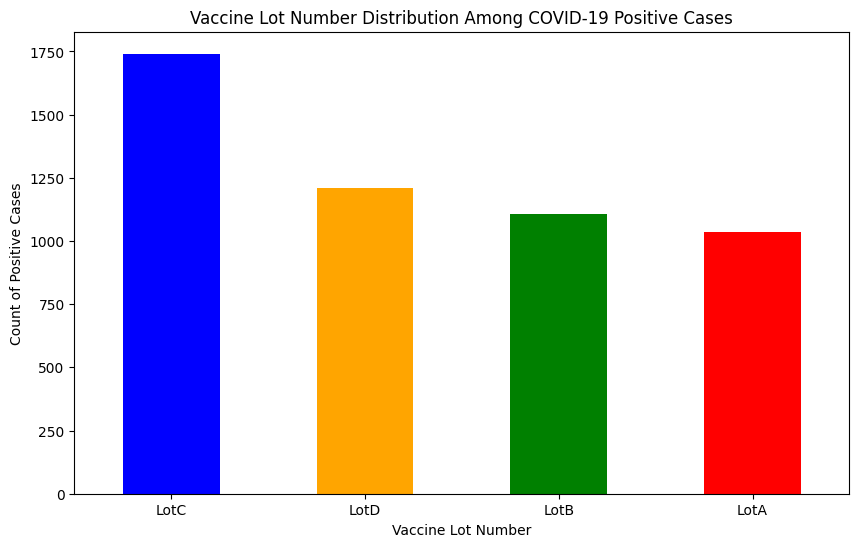

In [7]:
plt.figure(figsize=(10, 6))
lot_number_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.title('Vaccine Lot Number Distribution Among COVID-19 Positive Cases')
plt.xlabel('Vaccine Lot Number')
plt.ylabel('Count of Positive Cases')
plt.xticks(rotation=0)
plt.show()


In [9]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Prepare the data for the Isolation Forest model
lot_counts = lot_number_counts.values.reshape(-1, 1)

# Initialize and fit the model
iso_forest = IsolationForest(contamination=0.1)
iso_forest.fit(lot_counts)

# Predict outliers
outlier_predictions = iso_forest.predict(lot_counts)

# Append the predictions to the lot number counts
lot_number_counts_df = lot_number_counts.reset_index()
lot_number_counts_df.columns = ['AsiLotNo', 'Count']
lot_number_counts_df['Outlier'] = outlier_predictions


In [10]:
lot_number_counts_df

,AsiLotNo,Count,Outlier
0,LotC,1741,-1
1,LotD,1209,1
2,LotB,1107,1
3,LotA,1034,1


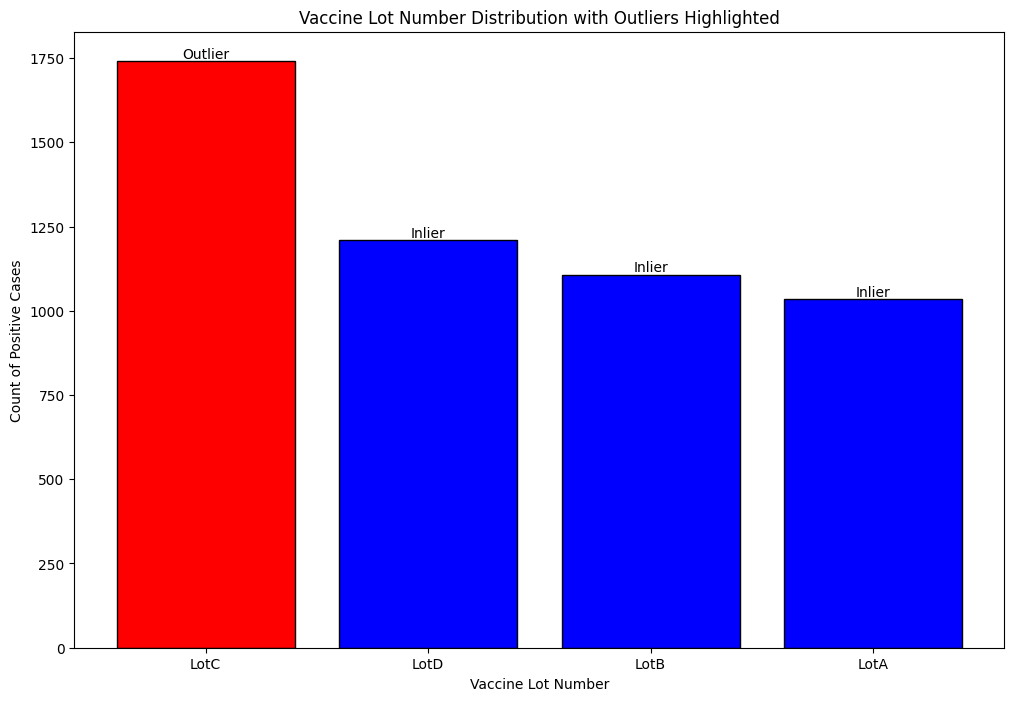

In [11]:

colors = ['red' if x == -1 else 'blue' for x in lot_number_counts_df['Outlier']]
labels = ['Outlier' if x == -1 else 'Inlier' for x in lot_number_counts_df['Outlier']]

plt.figure(figsize=(12, 8))

# Plot the bars with enhanced visualization
bars = plt.bar(lot_number_counts_df['AsiLotNo'], lot_number_counts_df['Count'], color=colors, edgecolor='black')

# Adding labels for clarity
for bar, label in zip(bars, labels):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, label, ha='center', va='bottom')

plt.title('Vaccine Lot Number Distribution with Outliers Highlighted')
plt.xlabel('Vaccine Lot Number')
plt.ylabel('Count of Positive Cases')
plt.xticks(rotation=0)
plt.show()
